## Library Import

In [1]:
!wget http://yaroslavvb.com/upload/notMNIST/notMNIST_small.mat

--2022-09-30 14:49:31--  http://yaroslavvb.com/upload/notMNIST/notMNIST_small.mat
Resolving yaroslavvb.com (yaroslavvb.com)... 129.121.4.193
Connecting to yaroslavvb.com (yaroslavvb.com)|129.121.4.193|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 117586976 (112M)
Saving to: ‘notMNIST_small.mat’

notMNIST_small.mat  100%[===================>] 112.14M  1.14MB/s    in 2m 53s  

2022-09-30 14:52:24 (665 KB/s) - ‘notMNIST_small.mat’ saved [117586976/117586976]



In [2]:
import matplotlib.pyplot as plt
from scipy import io
import numpy as np
from sklearn.model_selection import train_test_split

## Data Loading

In [3]:
data = io.loadmat("notMNIST_small.mat")

# transform data
X = data['images']
y = data['labels']
resolution = 28
classes = 10

X = np.transpose(X, (2, 0, 1))

y = y.astype('int32')
X = X.astype('float32')

# shape: (sample, x, y, channel)
X = X.reshape((-1, resolution, resolution, 1))

264


Text(0.5, 1.0, 'J')

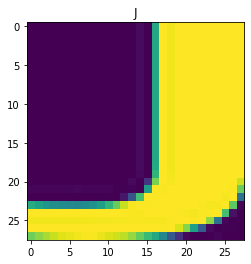

In [4]:
# looking at data
i = np.random.randint(0, 18723)
print(i)
plt.imshow( X[i,:,:,0] )
plt.title( "ABCDEFGHIJ"[y[i]] )

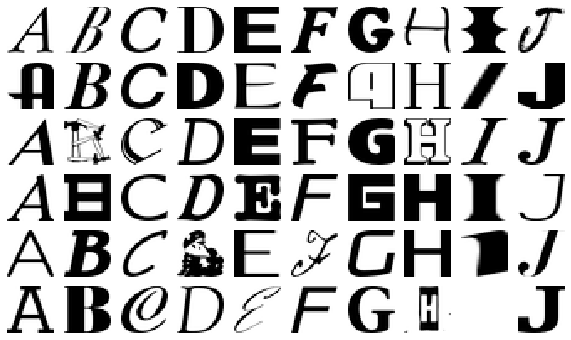

In [5]:
# random letters
rows = 6
fig, axs = plt.subplots(rows, classes, figsize=(classes, rows))

for letter_id in range(10):
    letters = X[y == letter_id]
    for i in range(rows):
        ax = axs[i, letter_id]
        ax.imshow(letters[np.random.randint(len(letters)),:,:,0],
                  cmap='Greys', interpolation='none')
        ax.axis('off')

In [6]:
# train test split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2022)

In [7]:
x_train.shape, y_train.shape

((14979, 28, 28, 1), (14979,))

In [8]:
# min-max scaling
max_n, min_n = x_train.max(), x_train.min()

x_train = (x_train - min_n) / (max_n - min_n)
x_test = (x_test - min_n) / (max_n - min_n)

In [9]:
x_train.max(), x_train.min()

(1.0, 0.0)

In [10]:
# one-hot encoding
from tensorflow.keras.utils import to_categorical

In [11]:
class_n = len(np.unique(y_train))

y_train = to_categorical(y_train, class_n)
y_test = to_categorical(y_test, class_n)

In [12]:
x_train.shape, y_train.shape

((14979, 28, 28, 1), (14979, 10))

## CNN Modeling

In [13]:
import pandas as pn

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers import BatchNormalization, Activation, Dropout

import random as rd
from sklearn.metrics import accuracy_score

In [14]:
x_train.shape

(14979, 28, 28, 1)

In [15]:
# 1. Session Clear
clear_session()

# 2. Model
model = Sequential()

# 3. Layer
model.add(Input(shape=(28, 28, 1)))

model.add(Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(10, activation='softmax'))

# 4. Compile
model.compile(loss=keras.losses.categorical_crossentropy, metrics=['accuracy'],
              optimizer='adam')

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 512)       5120      
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 512)      2048      
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 512)       2359808   
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 512)      2048      
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 512)       2359808   
                                                                 
 batch_normalization_2 (Batc  (None, 28, 28, 512)      2

In [17]:
# EarlyStopping
es = EarlyStopping(monitor='val_loss',
                   min_delta=0,
                   patience=5,
                   verbose=1,
                   restore_best_weights=True)

In [18]:
# 5. fit
history = model.fit(x_train, y_train, epochs=100, batch_size=64,
                    validation_split=0.2, verbose=1, callbacks=[es])

Epoch 1/100
188/188 [==============================] - 60s 235ms/step - loss: 0.3903 - accuracy: 0.8845 - val_loss: 1.8289 - val_accuracy: 0.3865
Epoch 2/100
188/188 [==============================] - 41s 216ms/step - loss: 0.2080 - accuracy: 0.9371 - val_loss: 0.9244 - val_accuracy: 0.6936
Epoch 3/100
188/188 [==============================] - 42s 226ms/step - loss: 0.1571 - accuracy: 0.9490 - val_loss: 0.3925 - val_accuracy: 0.8745
Epoch 4/100
188/188 [==============================] - 44s 236ms/step - loss: 0.1387 - accuracy: 0.9544 - val_loss: 0.2546 - val_accuracy: 0.9269
Epoch 5/100
188/188 [==============================] - 44s 237ms/step - loss: 0.0989 - accuracy: 0.9690 - val_loss: 0.2495 - val_accuracy: 0.9339
Epoch 6/100
188/188 [==============================] - 46s 244ms/step - loss: 0.0874 - accuracy: 0.9713 - val_loss: 0.2777 - val_accuracy: 0.9282
Epoch 7/100
188/188 [==============================] - 45s 241ms/step - loss: 0.0868 - accuracy: 0.9717 - val_loss: 0.2646 -

In [19]:
# 6. pred
y_pred = model.predict(x_test)

In [20]:
# 생성 예측값을 y_test 구조와 같게
pred_array = np.zeros(shape=(y_pred.shape[0], y_pred.shape[1]))
idx = 0

for arr_val in y_pred :
    # print(arr_val)
    pred_array[idx][arr_val.argmax()] = 1
    idx += 1

In [21]:
pred_array.shape

(3745, 10)

In [22]:
# 성능 평가
from sklearn.metrics import accuracy_score

In [23]:
print(f'{accuracy_score(y_test, pred_array):.4f}')

0.9458


## 문자 이미지 시각화

In [24]:
import random as rd

character = {0:'A', 1:'B', 2:'C', 3:'D', 4:'E', 5:'F', 6:'G', 7:'H', 8:'I', 9:'J'}

id = 2906
실제 문자 : H
모델의 문자 예측 : A
모델의 문자별 예측 확률 : [92.  1.  0.  0.  0.  0.  0.  2.  5.  0.]
오답


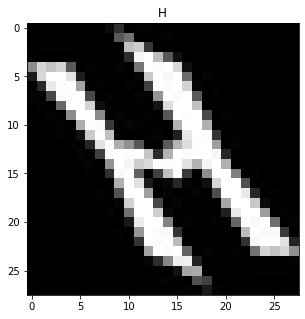

In [25]:
# 맞는 문자 확인
rand_n = rd.randrange(0, 3744)

print(f'id = {rand_n}')
print(f'실제 문자 : {character[y_test[rand_n].argmax()]}')
print(f'모델의 문자 예측 : {character[y_pred[rand_n].argmax()]}' )
print(f'모델의 문자별 예측 확률 : {np.round(y_pred[rand_n]*100)}')
# print(f'모델의 문자들 총 확률 : {sum(np.round(y_pred[rand_n]*100))}')

print('====================================================')

if y_test[rand_n].argmax() == y_pred[rand_n].argmax() :
    print('정답')
else :
    print('오답')

print('====================================================')

plt.figure(figsize=(5,5))
plt.imshow(x_test[rand_n].reshape(28, 28), cmap='gray')
plt.title("ABCDEFGHIJ"[y_test[rand_n].argmax()] )
plt.show()

id = 2868
실제 문자 : C
모델의 문자 예측 : G
모델의 문자별 예측 확률 : [ 0.  0.  1.  0.  0.  0. 99.  0.  0.  0.]
오답


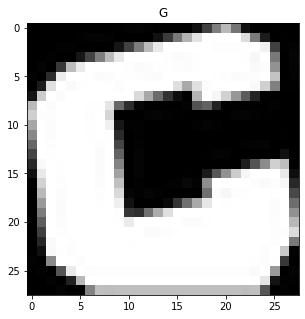

In [26]:
# 틀린 문자 확인
t_f = ( y_test.argmax(axis=1) == y_pred.argmax(axis=1) )
false_id = np.where(t_f==False)[0]
false_n = len(false_id)

id = false_id[rd.randrange(0, false_n)]

print(f'id = {id}')
print(f'실제 문자 : {character[y_test[id].argmax()]}')
print(f'모델의 문자 예측 : {character[y_pred[id].argmax()]}' )
print(f'모델의 문자별 예측 확률 : {np.round(y_pred[id]*100)}')
# print(f'모델의 문자들 총 확률 : {sum(np.round(y_pred[rand_n]*100))}')

print('====================================================')

if y_test[id].argmax() == y_pred[id].argmax() :
    print('정답')
else :
    print('오답')

print('====================================================')

plt.figure(figsize=(5,5))
plt.imshow(x_test[id].reshape(28, 28), cmap='gray')
plt.title("ABCDEFGHIJ"[y_pred[id].argmax()] )
plt.show()